‼️ 체크리스트

- DataLoader 설정이 최적화되어 있는지 확인할 것
- Trainer 생성 시
   체크포인트 저장 경로(root_dir)가 올바르게 설정되어 있는지 점검할 것

## 1. Import Required Packages

In [53]:
# from google.colab import drive

# drive.mount("/content/drive")

In [1]:
!pip install torchmetrics
!pip install pycocotools
!pip install faster-coco-eval
!pip install kagglehub
!pip install matplotlib
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 34.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 180.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 210.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 180.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.9/470.9 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import sys
import uuid
import shutil
from collections import Counter, OrderedDict

import kagglehub

from xml.etree import ElementTree as ET

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import torchvision
from torchvision import transforms
from torchvision.transforms import functional as T

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

from torchmetrics.detection.mean_ap import MeanAveragePrecision

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import cv2

import PIL

from tqdm.auto import tqdm

In [4]:
device = torch.device(
  "cuda" if torch.cuda.is_available() else
  "mps" if torch.backends.mps.is_available() else
  "cpu")
device

device(type='cuda')

In [5]:
diatom_dataset_root_dir = kagglehub.dataset_download("huseyingunduz/diatom-dataset")

diatom_images_dir = os.path.join(diatom_dataset_root_dir, "images")
diatom_xmls_dir = os.path.join(diatom_dataset_root_dir, "xmls")

100%|██████████| 8.71G/8.71G [01:06<00:00, 141MB/s] 

Extracting files...


## 2. Dataset Preparation

In [6]:
classes = {
  1: "Gomphonema olivaceum",
  2: "Navicula cryptotenella",
  3: "Fragilaria recapitellata",
  4: "Encyonema silesiacum",
  5: "Navicula reichardtiana",
  6: "Planothidium lanceolatum",
  7: "Gomphonema tergestinum",
  8: "Navicula cryptotenelloides",
  9: "Rhoicosphenia abbreviata",
  10: "Meridion circulare",
  11: "Surirella brebissonii var. kuetzingii",
  12: "Encyonema ventricosum",
  13: "Achnanthidium biasolettianum",
  14: "Cymbella excisa",
  15: "Diatoma moniliformis",
  16: "Cymbella cantonatii",
  17: "Diatoma mesodon",
  18: "Humidophila contenta",
  19: "Cocconeis pseudolineata",
  20: "Navicula upsaliensis",
  21: "Cymbella excisa var. subcapitata",
  22: "Halamphora veneta",
  23: "Gomphonema calcifugum",
  24: "Nitzschia linearis",
  25: "Pinnularia brebissonii",
  26: "Humidophila perpusilla",
  27: "Navicula trivialis",
  28: "Gomphonema pumilum var. rigidum",
  29: "Halamphora paraveneta",
  30: "Nitzschia hantzschiana",
  31: "Pantocsekiella ocellata",
  32: "Planothidium frequentissimum",
  33: "Adlafia minuscula",
  34: "Navicula cryptocephala",
  35: "Amphora pediculus",
  36: "Navicula tripunctata",
  37: "Navicula gregaria",
  38: "Nitzschia archibaldii",
  39: "Navicula moskalii",
  40: "Epithemia argus",
  41: "Gomphonema micropus",
  42: "Gomphonema minutum",
  43: "Navicula capitatoradiata",
  44: "Gomphonema drutelingense",
  45: "Denticula kuetzingii",
  46: "Gomphonema supertergestinum",
  47: "Achnanthidium minutissimum",
  48: "Frustulia vulgaris",
  49: "Gomphonema pumilum",
  50: "Hantzschiana abundans",
  51: "Caloneis lancettula",
  52: "Navicula novaesiberica",
  53: "Sellaphora radiosa",
  54: "Navicula lanceolata",
  55: "Gomphonema exilissimum",
  56: "Diploneis fontanella",
  57: "Luticola nivalis",
  58: "Epithemia goeppertiana",
  59: "Nitzschia recta",
  60: "Stauroneis blazenciciae",
  61: "Cymbopleura amphicephala",
  62: "Cymbella excisa var. procera",
  63: "Nitzschia palea",
  64: "Didymosphenia geminata",
  65: "Sellaphora saugerresii",
  66: "Amphora inariensis",
  67: "Neidiomorpha binodiformis",
  68: "Surella minuta"
}

class_to_idx = {v: k for k, v in classes.items()}

In [7]:
banned_xml_files = [
  "388.xml",
  "1147.xml",
  "366.xml",
  "1418.xml",
  "488.xml",
  "1256.xml",
  "475.xml",
  "1067.xml",
  "1310.xml",
  "453.xml",
  "284.xml",
  "233.xml",
  "437.xml",
]

In [8]:
def parse_xml(filepath):
  tree = ET.parse(filepath)
  root = tree.getroot()

  filename = root.find("filename").text + ".png"

  objs = []

  for obj in root.findall("objects/object"):
    class_name = obj.find("name").text

    xmin = int(obj.find("bbox/xmin").text)
    xmax = int(obj.find("bbox/xmax").text)
    ymin = int(obj.find("bbox/ymin").text)
    ymax = int(obj.find("bbox/ymax").text)

    objs.append({
      "class_name": class_name,
      "xmin": xmin,
      "xmax": xmax,
      "ymin": ymin,
      "ymax": ymax,
    })

  return {
    "filename": filename,
    "objects": objs
  }

parse_xml(os.path.join(diatom_xmls_dir, "25.xml"))

{'filename': '25.png',
 'objects': [{'class_name': 'Gomphonema drutelingense',
   'xmin': 604,
   'xmax': 874,
   'ymin': 1101,
   'ymax': 1248},
  {'class_name': 'Cymbella cantonatii',
   'xmin': 648,
   'xmax': 1227,
   'ymin': 839,
   'ymax': 1116}]}

In [9]:
class DiatomDataset(Dataset):
  def __init__(self, root_dir, classes, class_to_idx, banned_xml_files=[], transform=None, train=True):
    self.root_dir = root_dir
    self.classes = classes
    self.class_to_idx = class_to_idx
    self.transform = transform

    self.xml_dir = os.path.join(self.root_dir, "xmls")
    self.image_dir = os.path.join(self.root_dir, "images")

    self.xml_files = os.listdir(self.xml_dir)
    self.xml_files = [
      xml_file for xml_file in self.xml_files if xml_file.endswith(".xml") and xml_file not in banned_xml_files
    ]

    split_idx = int(len(self.xml_files) * 0.8)

    if train:
      self.xml_files = self.xml_files[:split_idx]
    else:
      self.xml_files = self.xml_files[split_idx:]

  def __len__(self):
    return len(self.xml_files)

  def __getitem__(self, index):
    xml = parse_xml(os.path.join(self.xml_dir, self.xml_files[index]))

    image_filename = os.path.join(self.image_dir, xml["filename"])

    image = PIL.Image.open(image_filename).convert("RGB")
    if self.transform:
      image = self.transform(image)

    boxes, labels = zip(*[
      (
        (*self._extract_bndbox(obj),), self.class_to_idx[obj["class_name"]]
      ) for obj in xml["objects"]
    ])

    target = {
      "boxes": torch.tensor(boxes, dtype=torch.float32),
      "labels": torch.tensor(labels, dtype=torch.int64),
    }

    return image, target

  def _extract_bndbox(self, obj):
    return obj["xmin"], obj["ymin"], obj["xmax"], obj["ymax"]

In [10]:
train_dataset = DiatomDataset(
  diatom_dataset_root_dir,
  classes,
  class_to_idx,
  banned_xml_files,
  transform=transforms.ToTensor(),
  train=True
)

test_dataset = DiatomDataset(
  diatom_dataset_root_dir,
  classes,
  class_to_idx,
  banned_xml_files,
  transform=transforms.ToTensor(),
  train=False
)

In [11]:
train_dataloader = DataLoader(
  dataset=train_dataset,
  batch_size=4,
  shuffle=True,
  num_workers=6,
  pin_memory=True,
  prefetch_factor=4,
  collate_fn=lambda batch: tuple(zip(*batch))
)

test_dataloader = DataLoader(
  dataset=test_dataset,
  batch_size=4,
  shuffle=False,
  num_workers=6,
  pin_memory=True,
  prefetch_factor=4,
  collate_fn=lambda batch: tuple(zip(*batch))
)

## 3. Train and Evaluation Tools

In [12]:
def to_device(images, targets):
  return [image.to(device) for image in images], [{k: v.to(device) for k, v in target.items()} for target in targets]

In [13]:
def train_epoch(dataloader, model, optimizer):
  total_loss = 0

  model.train()

  for images, targets in tqdm(dataloader, desc="Training"):
    images, targets = to_device(images, targets)

    loss_dict = model(images, targets)
    losses = sum(loss for loss in loss_dict.values())

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    total_loss += losses.item()

  return total_loss / len(dataloader)

def validate_epoch(dataloader, model):
  mean_ap = MeanAveragePrecision().to(device)

  model.eval()

  with torch.no_grad():
    for images, targets in tqdm(dataloader, desc="Validating"):
      images, targets = to_device(images, targets)

      outputs = model(images)

      mean_ap.update(outputs, targets)

  score = mean_ap.compute()
  score_cpu = {k: v.cpu() if torch.is_tensor(v) else v for k, v in score.items()}

  return score

In [14]:
def plot_detection_train_log(train_losses, val_maps, val_map_50s, val_map_75s):
  epochs = np.arange(1, len(train_losses) + 1)

  plt.figure(figsize=(15, 6))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_losses, label="Train Loss", marker='o', linewidth=2)
  plt.title("Training Loss over Epochs", fontsize=14)
  plt.xlabel("Epoch", fontsize=12)
  plt.ylabel("Loss", fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend(fontsize=10)

  plt.subplot(1, 2, 2)
  plt.plot(epochs, val_maps, label="mAP@[.5:.95]", marker='o', linewidth=2)
  plt.plot(epochs, val_map_50s, label="mAP@50", marker='s', linewidth=2)
  plt.plot(epochs, val_map_75s, label="mAP@75", marker='^', linewidth=2)
  plt.title("Validation mAP over Epochs", fontsize=14)
  plt.xlabel("Epoch", fontsize=12)
  plt.ylabel("mAP", fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.6)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10)
  plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
  plt.legend(fontsize=10)

  plt.tight_layout()
  plt.show()

In [15]:
class Trainer:
  def __init__(self, model, optimizer, train_dataloader, test_dataloader, root_dir="/workspace/checkpoints"):
    self.model = model
    self.optimizer = optimizer
    self.train_dataloader = train_dataloader
    self.test_dataloader = test_dataloader
    self.root_dir = root_dir

    self.complete_epoch = 0

    self.train_losses = []
    self.scores = []

    self.checkouts = {}

  def train(self, epoch, is_checkout=True):
    start_epoch = self.complete_epoch + 1

    for cur_epoch in range(start_epoch, start_epoch + epoch):
      loss = train_epoch(self.train_dataloader, self.model, self.optimizer)
      score = validate_epoch(self.test_dataloader, self.model)

      print(f"Epoch: {self.complete_epoch + 1} | "
          f"Train Loss: {loss:.3f} | "
          f"Val mAP: {score['map'].item():.3f} | "
          f"Val mAP@50: {score['map_50'].item():.3f} | "
          f"Val mAP@75: {score['map_75'].item():.3f}")

      self.train_losses.append(loss)
      self.scores.append(score)

      self.complete_epoch = cur_epoch

    if is_checkout:
      self.checkout()

    self.plot_log()

  def evaluate(self):
    score = validate_epoch(self.test_dataloader, self.model)

    print(f"Val mAP: {score['map'].item():.3f} | "
          f"Val mAP@50: {score['map_50'].item():.3f} | "
          f"Val mAP@75: {score['map_75'].item():.3f}")

    self.plot_log()

    return score

  def plot_log(self):
    if not self.scores:
        print("No evaluation scores to plot yet.")
        return

    val_maps, val_map_50s, val_map_75s = zip(*[
      (score["map"].item(), score["map_50"].item(), score["map_75"].item()) for score in self.scores
    ])

    plot_detection_train_log(self.train_losses, val_maps, val_map_50s, val_map_75s)

  def checkout(self):
    if self.complete_epoch in self.checkouts:
      return

    random_id = uuid.uuid4().hex[:8]

    os.makedirs(self.root_dir, exist_ok=True)

    output_path = os.path.join(self.root_dir, f"{random_id}-epoch{self.complete_epoch}.pt")

    self.checkouts[self.complete_epoch] = output_path

    torch.save(
      {
        "model_state_dict": self.model.state_dict(),
        "optimizer_state_dict": self.optimizer.state_dict(),
        "epoch": self.complete_epoch,
      },
      output_path
    )

  def load_checkpoint(self, checkpoint):
    if checkpoint not in self.checkouts:
      print(f"Checkpoint {checkpoint} not found.", file=sys.stderr)
      return

    checkpoint_data = torch.load(self.checkouts[checkpoint])
    self.model.load_state_dict(checkpoint_data["model_state_dict"])
    self.optimizer.load_state_dict(checkpoint_data["optimizer_state_dict"])
    self.complete_epoch = checkpoint

    print(f"Checkpoint {checkpoint} loaded.")

**`Trainer` 사용 예시**

```python
>>> trainer = Trainer(model, optimizer, train_dataloader, test_dataloader)

>>> trainer.train(epoch=5, checkout=True) # 첫 5 에포크 학습
    # ... 로그, 지표, 그래프 출력

>>> trainer.train(epoch=5, checkout=True) # 추가 5 에포크 학습
    # ... 로그, 지표, 그래프 출력

>>> trainer.load_checkpoint(checkpoint=5) # 해당 체크포인트로 모델, 옵티마이저 이동

>>> trainer.evaluate()
    # ... 지표, 그래프 출력
```

## 4. Load a Pre-trained Model

In [16]:
def get_fasterrcnn_model(num_classes):
  weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
  model = fasterrcnn_resnet50_fpn(weights=weights)

  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

  return model

## 5. Finetune - Only head

In [17]:
model = get_fasterrcnn_model(len(classes) + 1)
model.to(device)

for param in model.backbone.parameters():
    param.requires_grad = False

optimizer = torch.optim.SGD(
  [p for p in model.parameters() if p.requires_grad],
  lr=0.005,
  momentum=0.9,
)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 312MB/s] 


In [18]:
trainer = Trainer(model, optimizer, train_dataloader, test_dataloader)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>Exception ignored in: Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>Traceback (most recent call last):


Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
          File "/usr/local/lib/python3.10/dist-packages/torch/util

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch: 1 | Train Loss: 0.384 | Val mAP: 0.020 | Val mAP@50: 0.032 | Val mAP@75: 0.023


Epoch: 2 | Train Loss: 0.280 | Val mAP: 0.068 | Val mAP@50: 0.101 | Val mAP@75: 0.088


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40><function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>

Exception ignored in: Traceback (most recent call last):
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

self._shutdown_workers()      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers


Epoch: 3 | Train Loss: 0.236 | Val mAP: 0.089 | Val mAP@50: 0.122 | Val mAP@75: 0.111


Epoch: 4 | Train Loss: 0.209 | Val mAP: 0.104 | Val mAP@50: 0.149 | Val mAP@75: 0.119


Epoch: 5 | Train Loss: 0.190 | Val mAP: 0.125 | Val mAP@50: 0.176 | Val mAP@75: 0.150


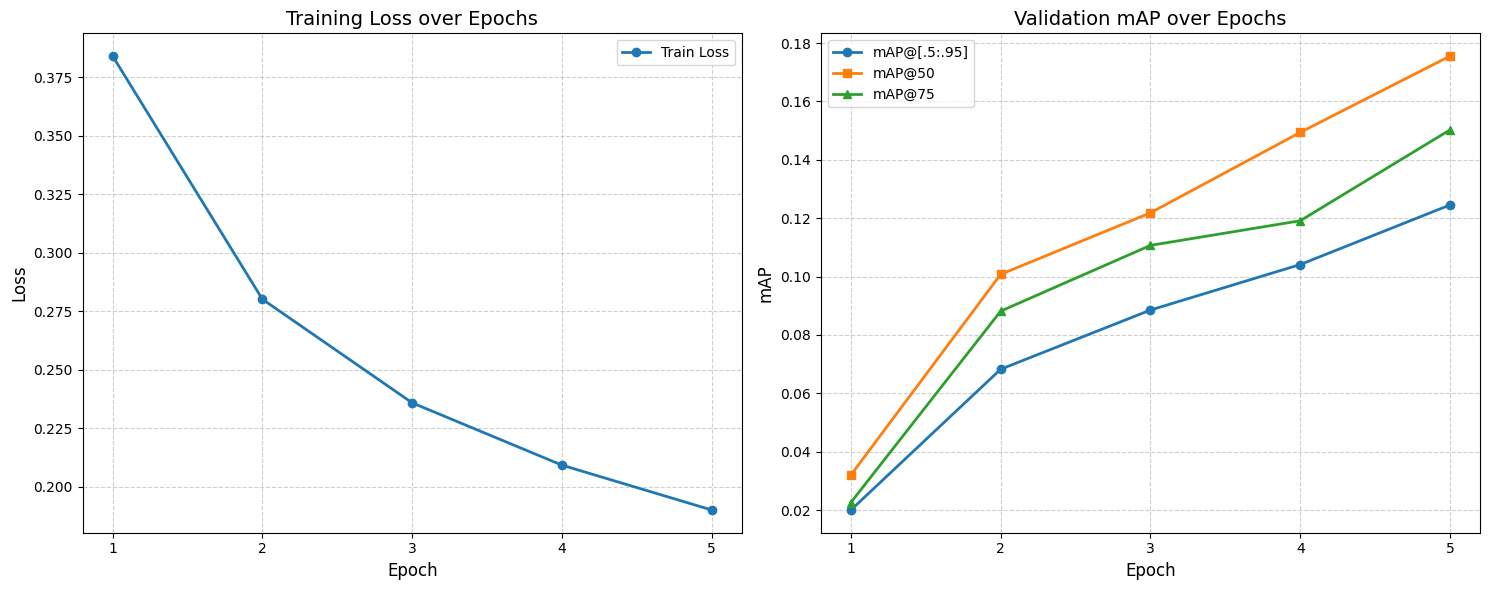

In [19]:
trainer.train(5)

Epoch: 6 | Train Loss: 0.175 | Val mAP: 0.128 | Val mAP@50: 0.179 | Val mAP@75: 0.169


Epoch: 7 | Train Loss: 0.162 | Val mAP: 0.140 | Val mAP@50: 0.186 | Val mAP@75: 0.180


Epoch: 8 | Train Loss: 0.152 | Val mAP: 0.149 | Val mAP@50: 0.206 | Val mAP@75: 0.176


Epoch: 9 | Train Loss: 0.145 | Val mAP: 0.168 | Val mAP@50: 0.222 | Val mAP@75: 0.220


Epoch: 10 | Train Loss: 0.137 | Val mAP: 0.208 | Val mAP@50: 0.275 | Val mAP@75: 0.264


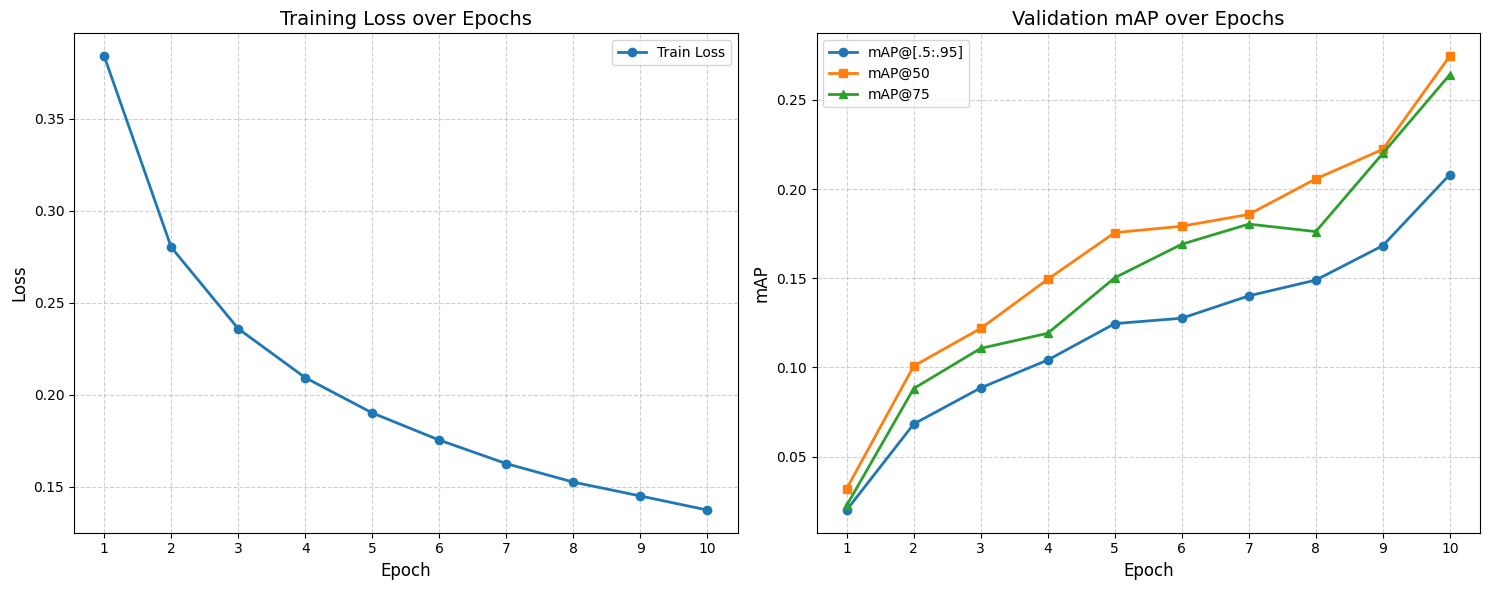

In [20]:
trainer.train(5)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 11 | Train Loss: 0.129 | Val mAP: 0.176 | Val mAP@50: 0.240 | Val mAP@75: 0.198


Epoch: 12 | Train Loss: 0.124 | Val mAP: 0.214 | Val mAP@50: 0.292 | Val mAP@75: 0.258


Epoch: 13 | Train Loss: 0.118 | Val mAP: 0.228 | Val mAP@50: 0.308 | Val mAP@75: 0.284


Epoch: 14 | Train Loss: 0.114 | Val mAP: 0.225 | Val mAP@50: 0.297 | Val mAP@75: 0.263


Epoch: 15 | Train Loss: 0.109 | Val mAP: 0.260 | Val mAP@50: 0.352 | Val mAP@75: 0.321


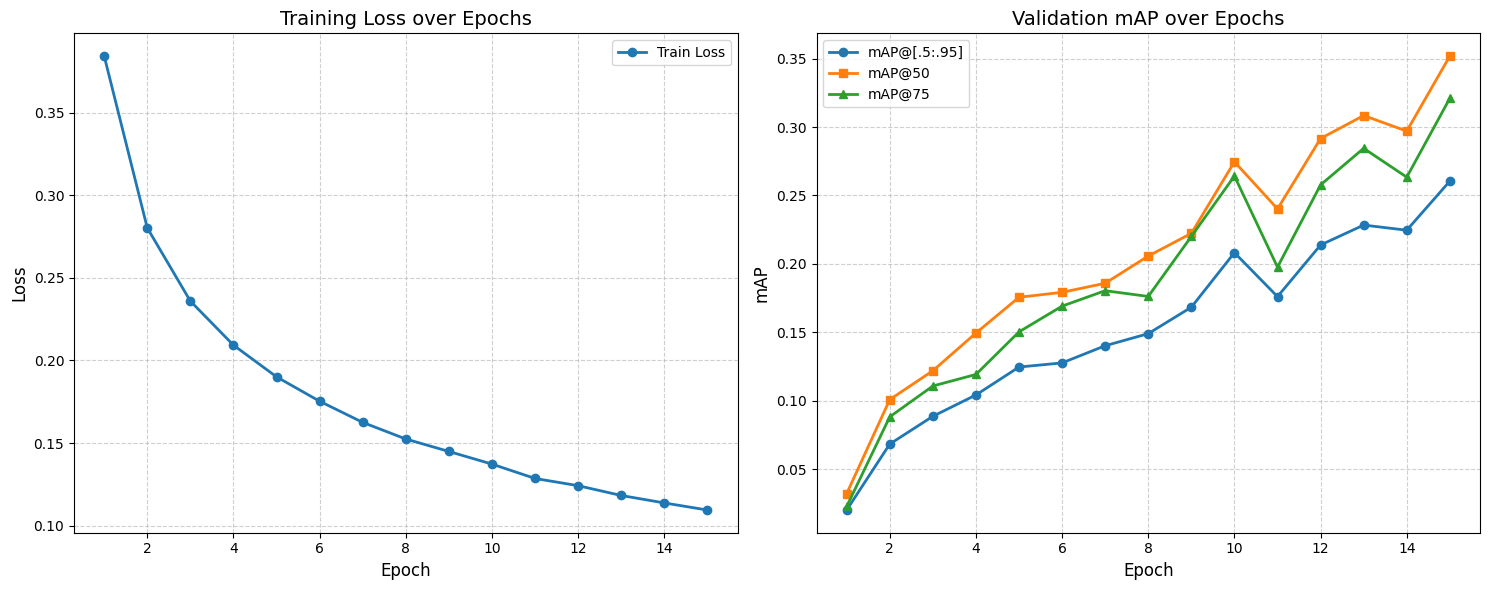

In [21]:
trainer.train(5)

Epoch: 16 | Train Loss: 0.104 | Val mAP: 0.265 | Val mAP@50: 0.344 | Val mAP@75: 0.312


Epoch: 17 | Train Loss: 0.101 | Val mAP: 0.286 | Val mAP@50: 0.376 | Val mAP@75: 0.337


Epoch: 18 | Train Loss: 0.098 | Val mAP: 0.281 | Val mAP@50: 0.367 | Val mAP@75: 0.333


Epoch: 19 | Train Loss: 0.092 | Val mAP: 0.284 | Val mAP@50: 0.383 | Val mAP@75: 0.352


Epoch: 20 | Train Loss: 0.090 | Val mAP: 0.282 | Val mAP@50: 0.373 | Val mAP@75: 0.341


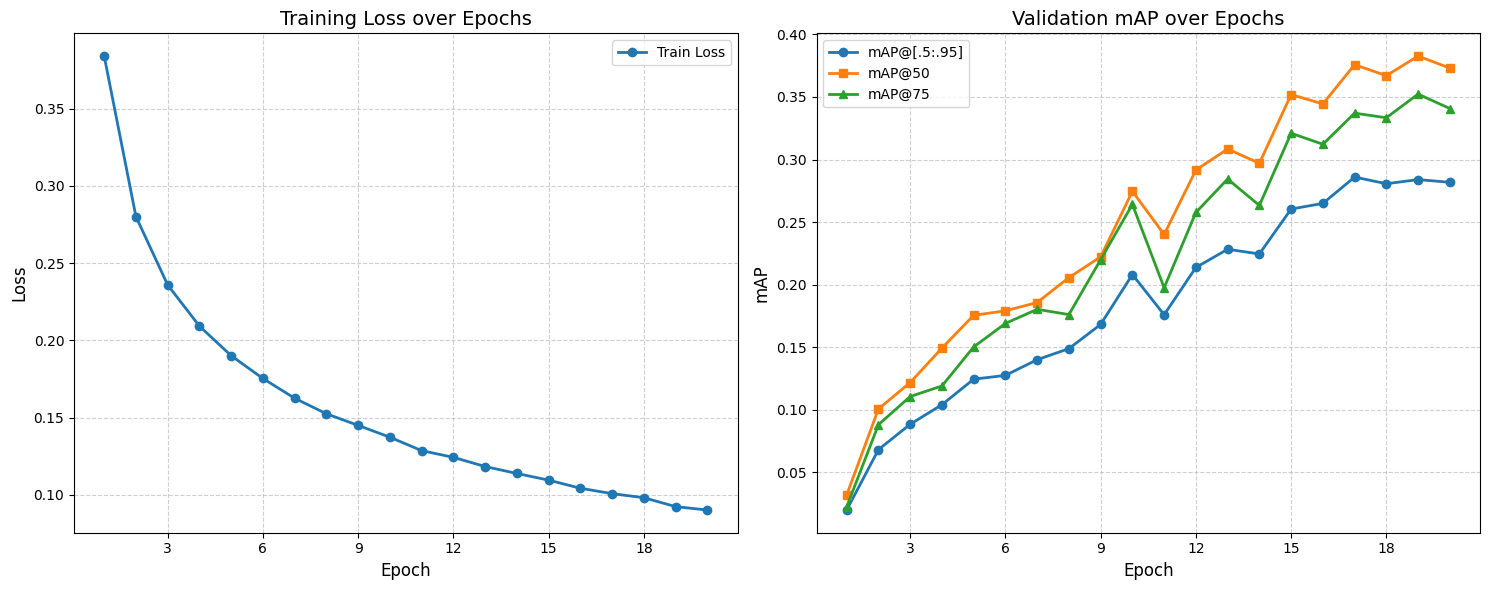

In [22]:
trainer.train(5)

## 6. Finetune - Full

**🚨 직전 실험 결과를 백업했나요?? 🚨**

In [23]:
model = get_fasterrcnn_model(len(classes) + 1)
model.to(device)

# for param in model.backbone.parameters():
#     param.requires_grad = False

optimizer = torch.optim.SGD(
  [p for p in model.parameters() if p.requires_grad],
  lr=0.005,
  momentum=0.9,
)

In [24]:
trainer = Trainer(model, optimizer, train_dataloader, test_dataloader)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 1 | Train Loss: 0.392 | Val mAP: 0.035 | Val mAP@50: 0.048 | Val mAP@75: 0.041


Epoch: 2 | Train Loss: 0.259 | Val mAP: 0.134 | Val mAP@50: 0.178 | Val mAP@75: 0.168


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():
    if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

Epoch: 3 | Train Loss: 0.193 | Val mAP: 0.252 | Val mAP@50: 0.321 | Val mAP@75: 0.311


Epoch: 4 | Train Loss: 0.143 | Val mAP: 0.237 | Val mAP@50: 0.307 | Val mAP@75: 0.291


Epoch: 5 | Train Loss: 0.120 | Val mAP: 0.303 | Val mAP@50: 0.398 | Val mAP@75: 0.358


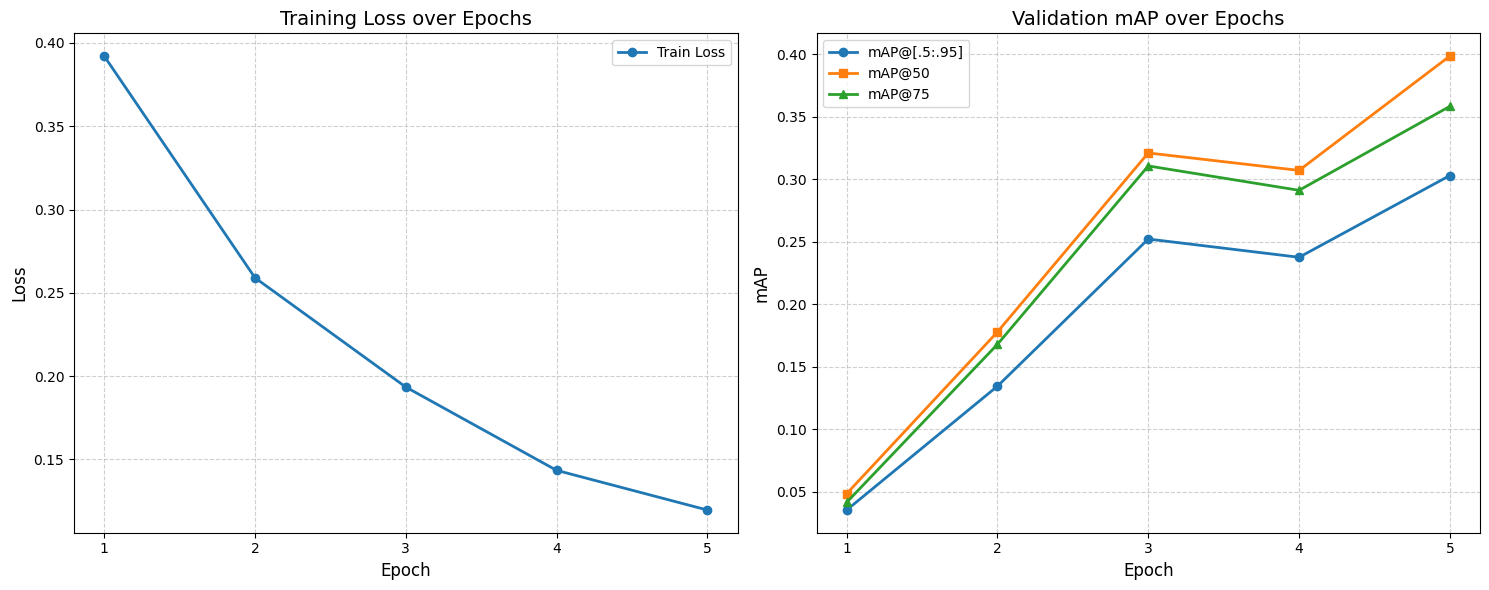

In [25]:
trainer.train(5)

Epoch: 6 | Train Loss: 0.099 | Val mAP: 0.317 | Val mAP@50: 0.417 | Val mAP@75: 0.380


Epoch: 7 | Train Loss: 0.088 | Val mAP: 0.364 | Val mAP@50: 0.455 | Val mAP@75: 0.426


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():Exception ignored 

Epoch: 8 | Train Loss: 0.077 | Val mAP: 0.421 | Val mAP@50: 0.527 | Val mAP@75: 0.515


Epoch: 9 | Train Loss: 0.069 | Val mAP: 0.403 | Val mAP@50: 0.512 | Val mAP@75: 0.495


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch: 10 | Train Loss: 0.062 | Val mAP: 0.431 | Val mAP@50: 0.520 | Val mAP@75: 0.509


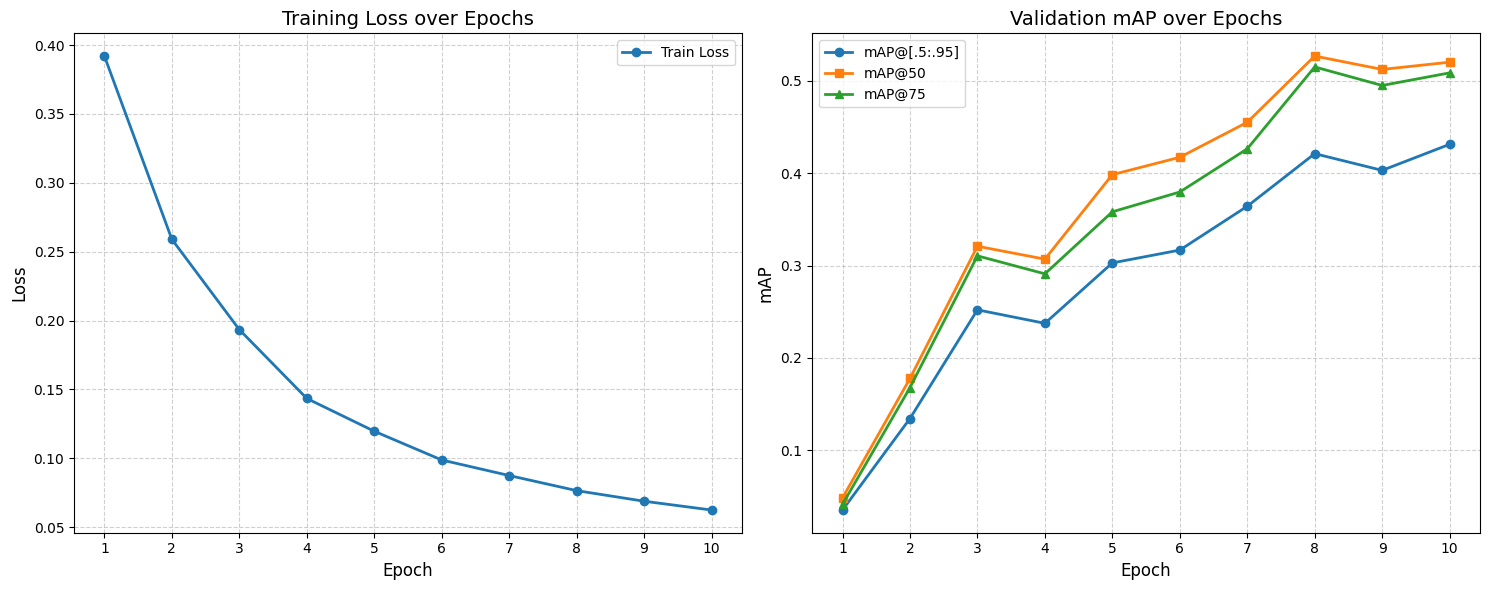

In [26]:
trainer.train(5)

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 11 | Train Loss: 0.057 | Val mAP: 0.446 | Val mAP@50: 0.550 | Val mAP@75: 0.522


Epoch: 12 | Train Loss: 0.054 | Val mAP: 0.433 | Val mAP@50: 0.541 | Val mAP@75: 0.523


Epoch: 13 | Train Loss: 0.047 | Val mAP: 0.447 | Val mAP@50: 0.546 | Val mAP@75: 0.535


Epoch: 14 | Train Loss: 0.045 | Val mAP: 0.464 | Val mAP@50: 0.570 | Val mAP@75: 0.541


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f7dad0e1b40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch: 15 | Train Loss: 0.041 | Val mAP: 0.471 | Val mAP@50: 0.554 | Val mAP@75: 0.549


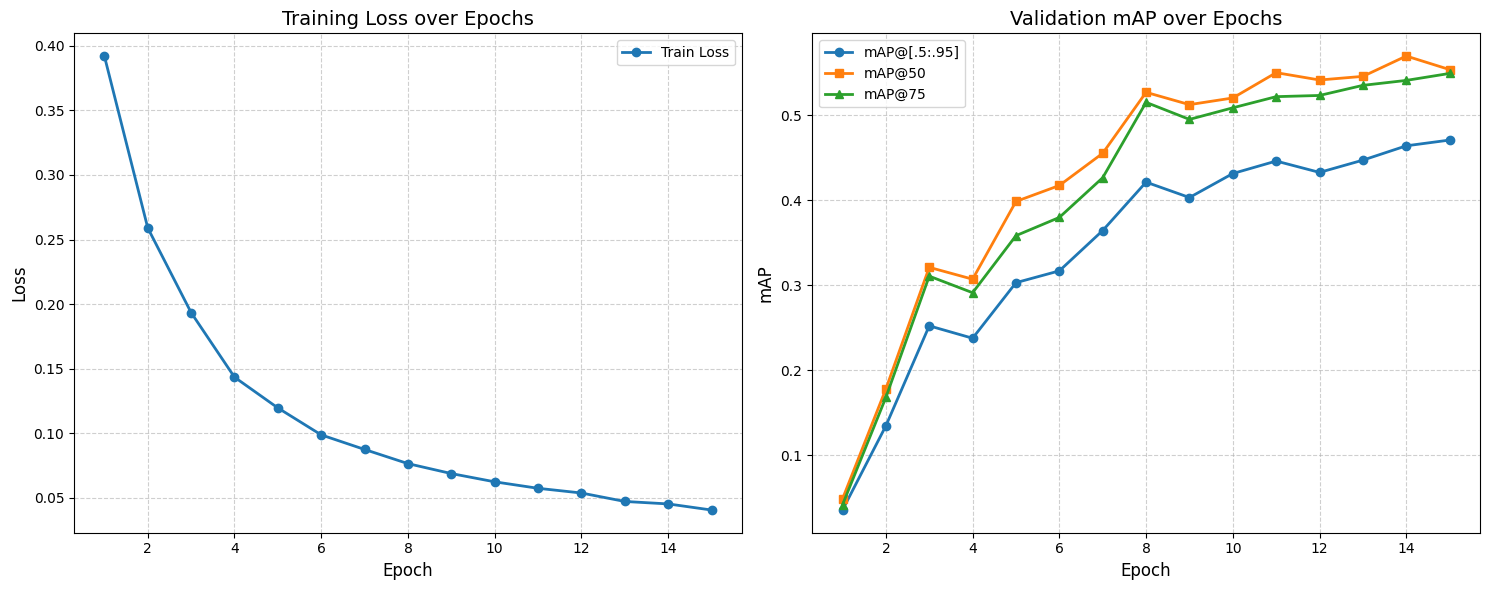

In [27]:
trainer.train(5)

Epoch: 16 | Train Loss: 0.038 | Val mAP: 0.466 | Val mAP@50: 0.561 | Val mAP@75: 0.555


Epoch: 17 | Train Loss: 0.037 | Val mAP: 0.449 | Val mAP@50: 0.533 | Val mAP@75: 0.524


Epoch: 18 | Train Loss: 0.033 | Val mAP: 0.471 | Val mAP@50: 0.555 | Val mAP@75: 0.543


Epoch: 19 | Train Loss: 0.031 | Val mAP: 0.461 | Val mAP@50: 0.544 | Val mAP@75: 0.538


Epoch: 20 | Train Loss: 0.030 | Val mAP: 0.463 | Val mAP@50: 0.545 | Val mAP@75: 0.540


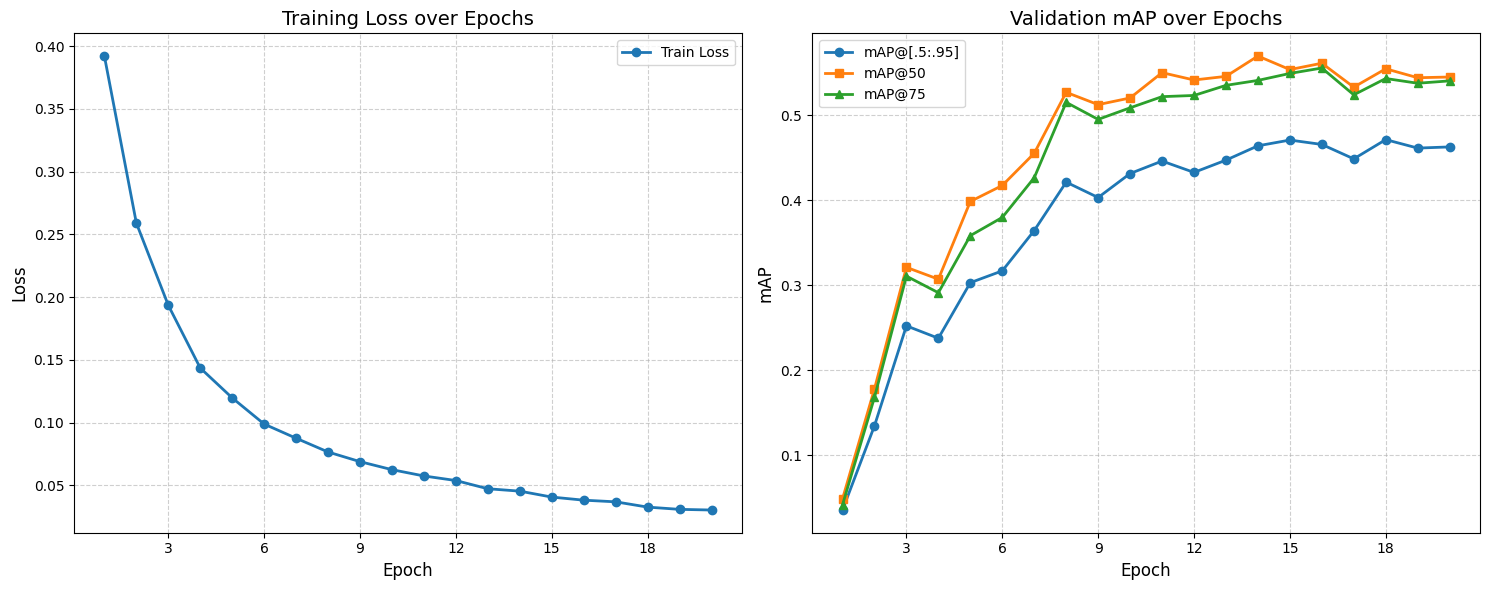

In [28]:
trainer.train(5)